# 환경 준비

In [1]:
!pip install --upgrade tf-keras-vis

     |████████████████████████████████| 53 kB 891 kB/s 


In [2]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf


from tensorflow.keras import backend as K
from tf_keras_vis.utils import normalize
from matplotlib import cm

# 모뎅 로딩

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

# 데이터 준비

In [4]:
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/goldfish.jpg
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/bear.jpg
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/soldiers.jpg

--2022-01-03 04:08:00--  https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/goldfish.jpg
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/keisen/tf-keras-vis/master/docs/examples/images/goldfish.jpg [following]
--2022-01-03 04:08:00--  https://raw.githubusercontent.com/keisen/tf-keras-vis/master/docs/examples/images/goldfish.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8833 (8.6K) [image/jpeg]
Saving to: ‘goldfish.jpg’

goldfish.jpg        100%[===================>]   8.63K  --.-KB/s    in 0s      

2022-01-03 04:08:00 (54.9 MB/s) - ‘goldfish.jpg’ saved [8833/8833]


In [5]:
from tensorflow.keras.preprocessing.image import load_img

img1 = load_img('goldfish.jpg', target_size=(224, 224))
img2 = load_img('bear.jpg', target_size=(224, 224))
img3 = load_img('soldiers.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

GOLDFISH_CATEGORY_INDEX = 1
BEAR_CATEGORY_INDEX = 294
ASSAULT_RIFLE_CATEGORY_INDEX = 413

labels = [GOLDFISH_CATEGORY_INDEX, BEAR_CATEGORY_INDEX, ASSAULT_RIFLE_CATEGORY_INDEX]

In [8]:
print(images.shape)
print(labels)

(3, 224, 224, 3)
[1, 294, 413]


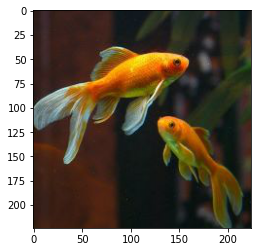

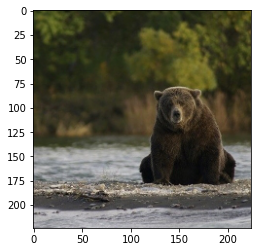

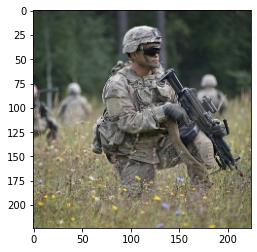

In [9]:
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()

# GradCAM 실행

In [12]:
def draw_gradcam(model, images, labels, preprocess):
    
    X = preprocess(images)

    def loss(output):
        return [ output[i][labels[i]] for i in range(len(labels)) ]

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    from tf_keras_vis.gradcam import GradcamPlusPlus

    gradcam = GradcamPlusPlus(model, model_modifier, clone=False)

    TARGET_LAYER_NUMBER = -1 # 마지막 층
    # Generate heatmap with GradCAM++
    cam = gradcam(loss, X, penultimate_layer=TARGET_LAYER_NUMBER)

    for i in range(len(images)):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        plt.imshow(images[i])
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.show()          

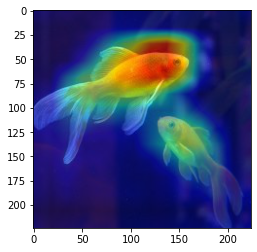

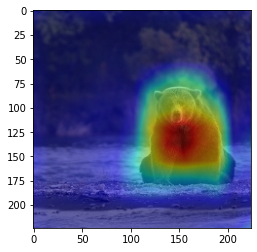

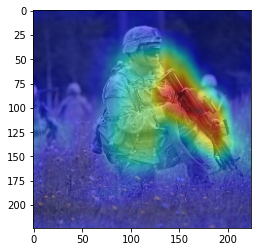

In [13]:
def preprocess(img):
    return preprocess_input(img)

draw_gradcam(model, images, labels, preprocess)

# Faster- ScoreCAM 실행

In [14]:
def draw_fast_score_gradcam(model, images, labels, preprocess):

    X = preprocess(images)

    def loss(output):
        return [ output[i][labels[i]] for i in range(len(labels)) ]

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m    

    from tf_keras_vis.scorecam import ScoreCAM

    scorecam = ScoreCAM(model, model_modifier, clone=False)

    TARGET_LAYER_NUMBER = -1 # 마지막 층
    cam = scorecam(loss, X, penultimate_layer=TARGET_LAYER_NUMBER, max_N=10)

    cam = normalize(cam)

    for i in range(len(images)):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        plt.imshow(images[i])
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.show()                


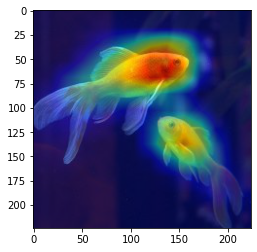

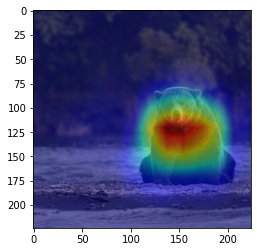

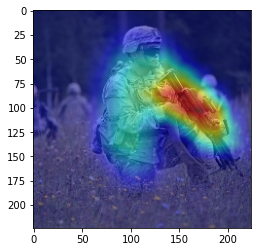

In [15]:
def preprocess(img):
    return preprocess_input(img)
    
draw_fast_score_gradcam(model, images, labels, preprocess)